In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
raw_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

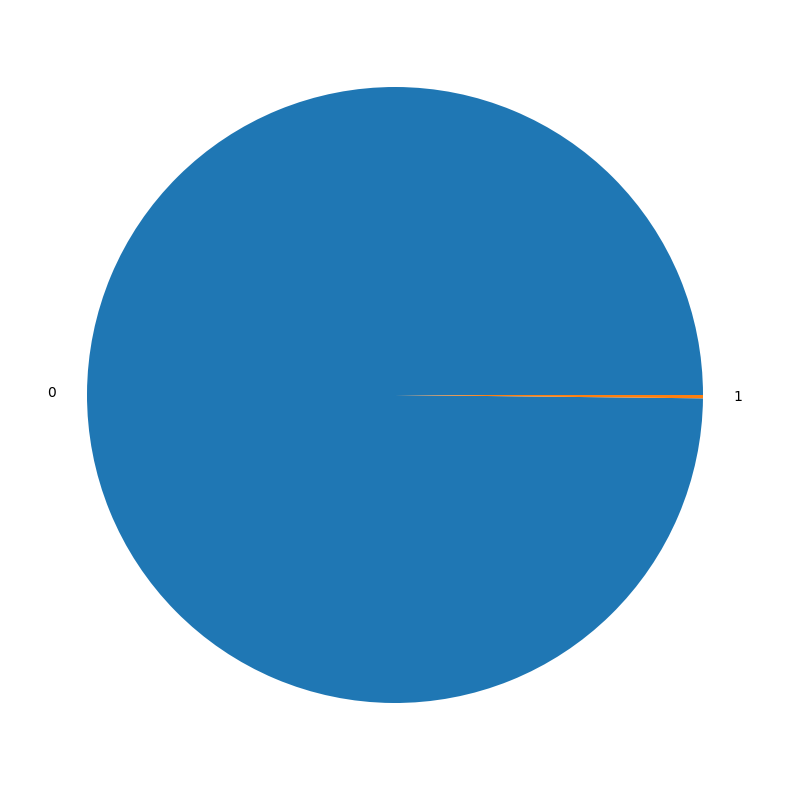

In [ ]:
dc= raw_df.value_counts('Class')
plt.pie(dc.values, labels=dc.index);

In [ ]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [ ]:
df=raw_df.drop('Time', axis=1)
df['Log Amount'] = np.log(raw_df.pop('Amount')+0.001)

In [ ]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [ ]:
train, test= train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
y_train = np.array(train.pop('Class'))
bool_train_labels = y_train != 0
y_val = np.array(val.pop('Class'))
y_test = np.array(test.pop('Class'))
x_train = np.array(train)
x_val = np.array(val)
x_test = np.array(test)

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((182276, 30), (182276,), (45569, 30), (45569,), (56962, 30), (56962,))

In [ ]:
x=df.drop('Class', axis=1)
y=df.Class
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((227845, 30), (227845,), (56962, 30), (56962,))

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.4)
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0

In [ ]:
scaler = StandardScaler()
x_train = StandardScaler().fit_transform(x_train)

x_test = StandardScaler().fit_transform(x_test)

x_train = np.clip(x_train, -5, 5)
x_test = np.clip(x_test, -5, 5)

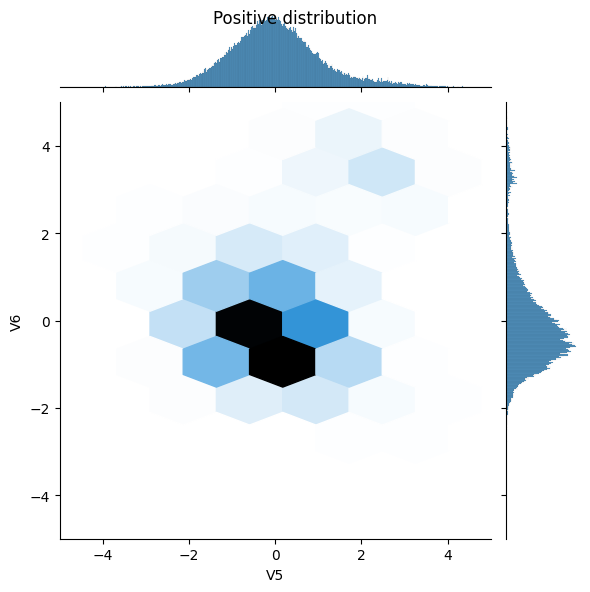

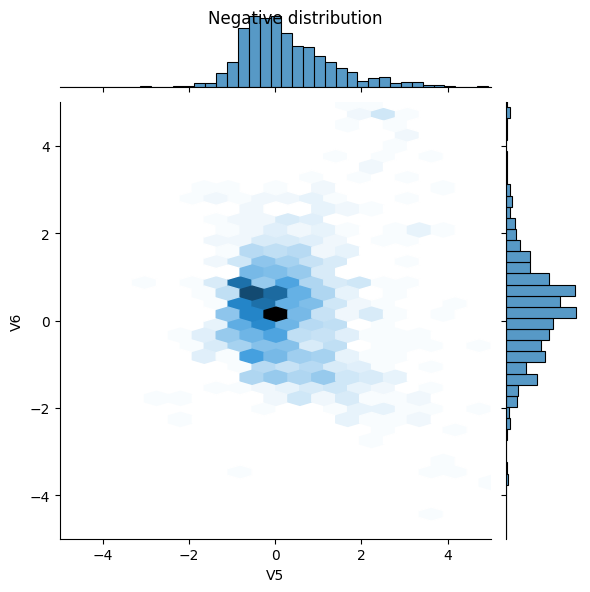

In [ ]:
pos_df = pd.DataFrame(train[ bool_train_labels], columns=train.columns)
neg_df = pd.DataFrame(train[~bool_train_labels], columns=train.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [ ]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          32, activation='relu',
          input_shape=(x_train.shape[-1],)),
      keras.layers.Dense(
          16, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc', verbose=1, patience=10, mode='max', restore_best_weights=True)
model = make_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 32)                992       
                                                                 
 dense_21 (Dense)            (None, 16)                528       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size= 2048, callbacks=[early_stopping], validation_data=(x_val, y_val))

Epoch 1/100
90/90 [==============================] - 9s 49ms/step - loss: 0.5508 - cross entropy: 0.5508 - Brier score: 0.1961 - tp: 62.0000 - fp: 61931.0000 - tn: 120038.0000 - fn: 245.0000 - accuracy: 0.6589 - precision: 0.0010 - recall: 0.2020 - auc: 0.3289 - prc: 0.0012 - val_loss: 0.1434 - val_cross entropy: 0.1434 - val_Brier score: 0.0056 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 45489.0000 - val_fn: 79.0000 - val_accuracy: 0.9982 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4499 - val_prc: 0.0015
Epoch 2/100
90/90 [==============================] - 1s 11ms/step - loss: 0.0910 - cross entropy: 0.0910 - Brier score: 0.0221 - tp: 26.0000 - fp: 4292.0000 - tn: 177677.0000 - fn: 281.0000 - accuracy: 0.9749 - precision: 0.0060 - recall: 0.0847 - auc: 0.5823 - prc: 0.0071 - val_loss: 0.1305 - val_cross entropy: 0.1305 - val_Brier score: 0.0017 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 45490.0000 - val_fn: 78.0000 - val_accuracy: 0.9983 - val_precision:

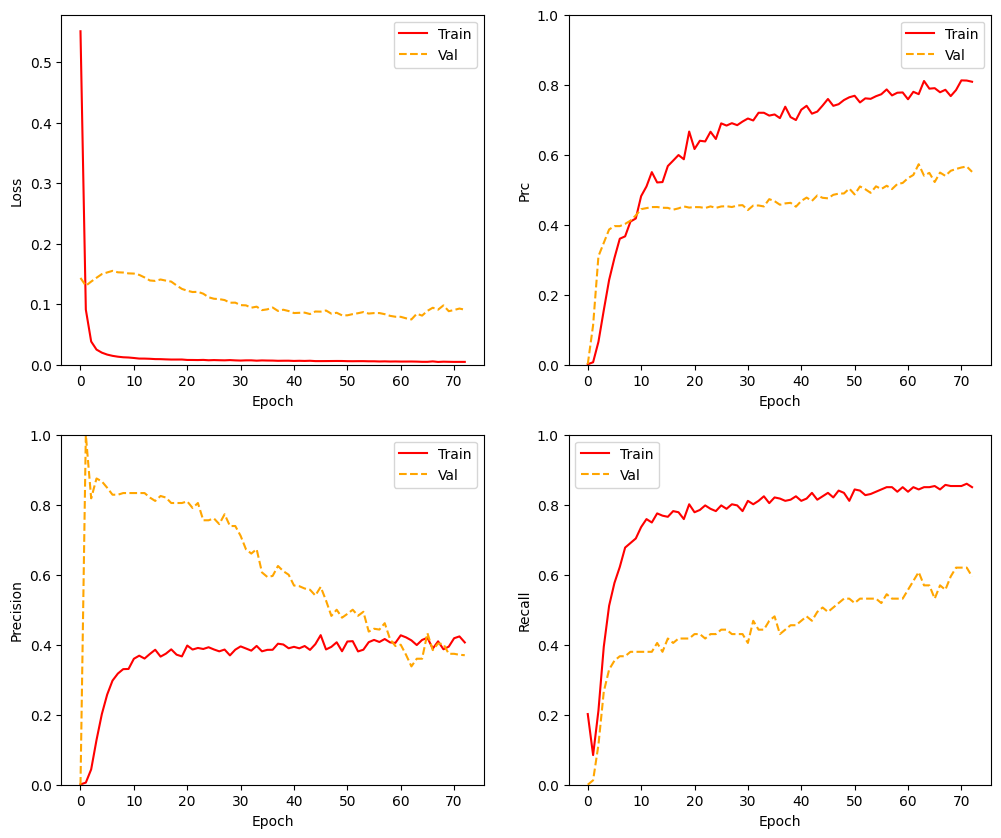

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='red', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='orange', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
plot_metrics(history)

In [ ]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:
train_predictions_baseline = model.predict(x_train, batch_size=2048)
test_predictions_baseline = model.predict(x_test, batch_size=2048)

28/28 [==============================] - 0s 2ms/step


loss :  0.0050769406370818615
cross entropy :  0.0050769406370818615
Brier score :  0.000553413643501699
tp :  85.0
fp :  18.0
tn :  56838.0
fn :  21.0
accuracy :  0.9993153214454651
precision :  0.8252426981925964
recall :  0.801886796951294
auc :  0.9196624755859375
prc :  0.8028911352157593

Legitimate Transactions Detected (True Negatives):  56838
Legitimate Transactions Incorrectly Detected (False Positives):  18
Fraudulent Transactions Missed (False Negatives):  21
Fraudulent Transactions Detected (True Positives):  85
Total Fraudulent Transactions:  106


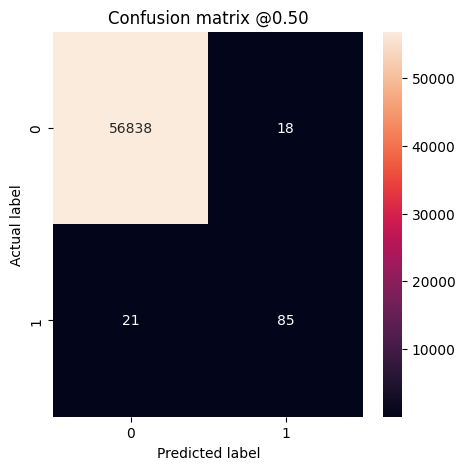

In [ ]:
baseline_results = model.evaluate(x_test, y_test,
                                  batch_size=2048, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

Legitimate Transactions Detected (True Negatives):  56832
Legitimate Transactions Incorrectly Detected (False Positives):  24
Fraudulent Transactions Missed (False Negatives):  19
Fraudulent Transactions Detected (True Positives):  87
Total Fraudulent Transactions:  106
Legitimate Transactions Detected (True Negatives):  56801
Legitimate Transactions Incorrectly Detected (False Positives):  55
Fraudulent Transactions Missed (False Negatives):  17
Fraudulent Transactions Detected (True Positives):  89
Total Fraudulent Transactions:  106


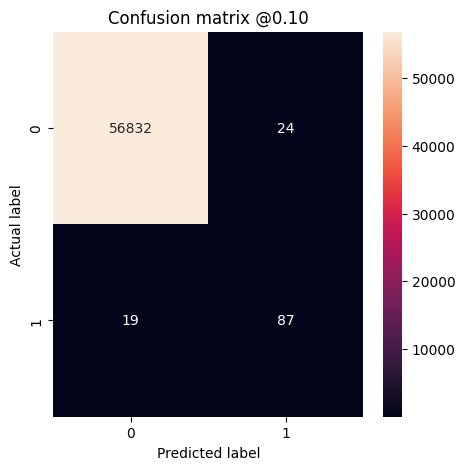

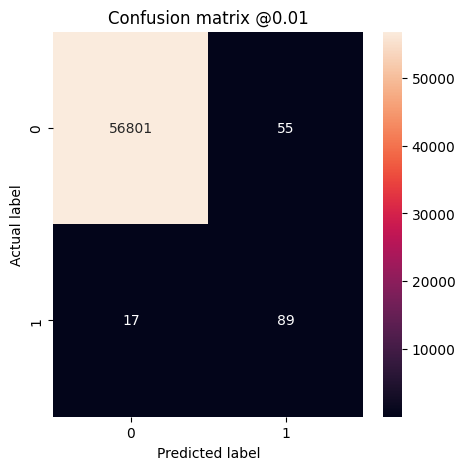

In [ ]:
plot_cm(y_test, test_predictions_baseline, threshold=0.1)
plot_cm(y_test, test_predictions_baseline, threshold=0.01)

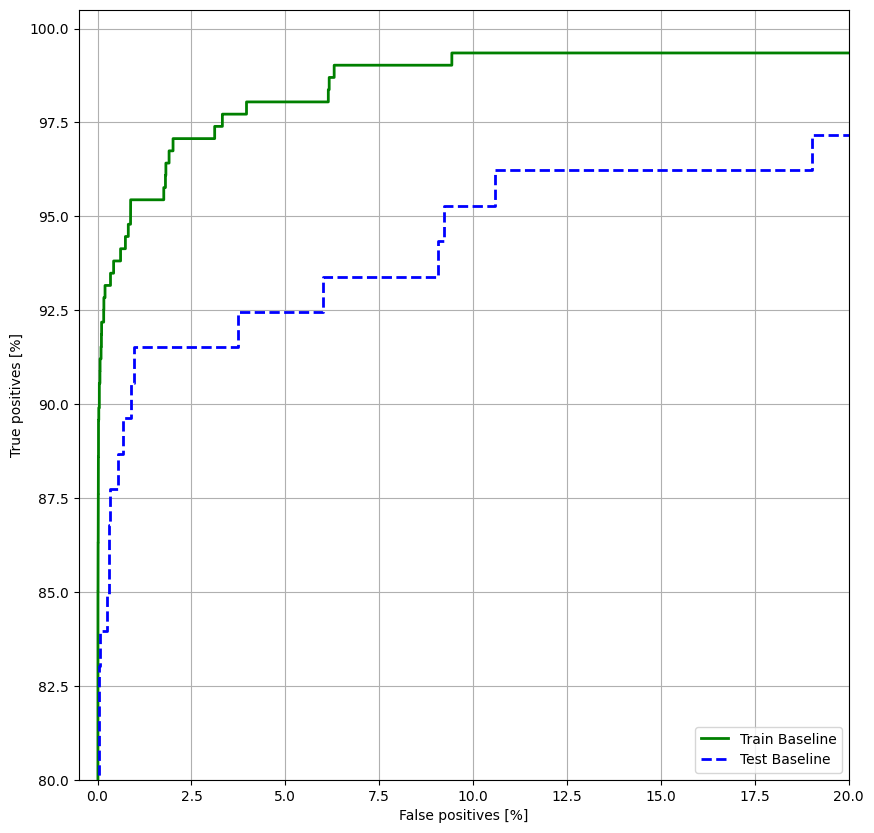

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Train Baseline", y_train, train_predictions_baseline, color='green')
plot_roc("Test Baseline", y_test, test_predictions_baseline, color='blue', linestyle='--')
plt.legend(loc='lower right');

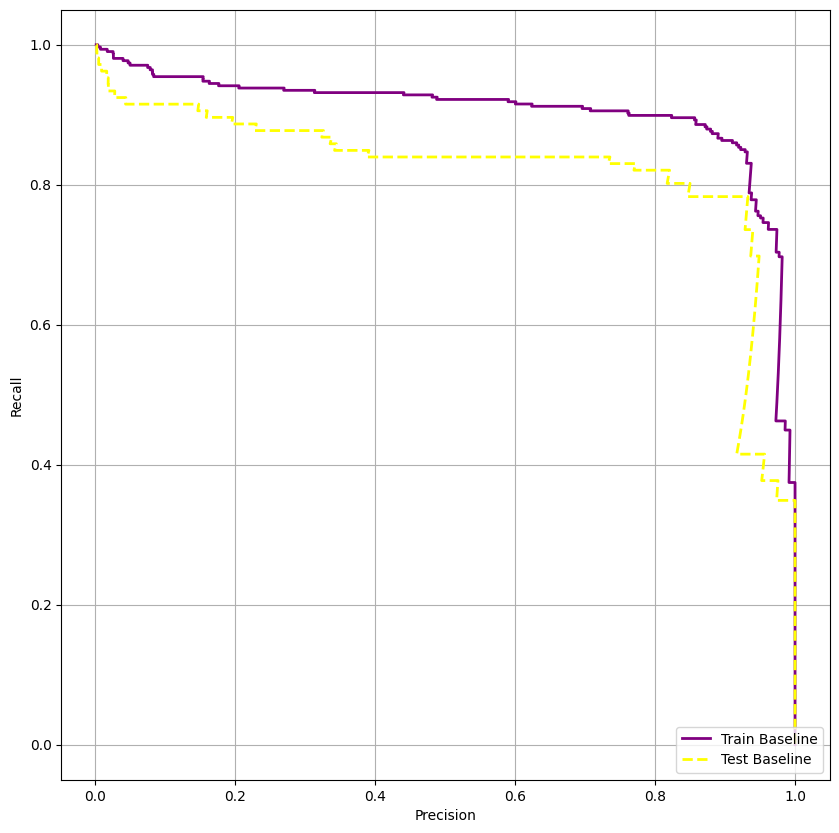

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
plot_prc("Train Baseline", y_train, train_predictions_baseline, color='purple')
plot_prc("Test Baseline", y_test, test_predictions_baseline, color='yellow', linestyle='--')
plt.legend(loc='lower right');

In [ ]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [ ]:
weighted_model = make_model()
weighted_history = weighted_model.fit(x_train, y_train, batch_size=2048, epochs=100, callbacks=[early_stopping], validation_data=(x_val, y_val),
                                      class_weight=class_weight)

Epoch 1/100
90/90 [==============================] - 3s 14ms/step - loss: 0.5991 - cross entropy: 0.7602 - Brier score: 0.2845 - tp: 371.0000 - fp: 131661.0000 - tn: 107164.0000 - fn: 42.0000 - accuracy: 0.4495 - precision: 0.0028 - recall: 0.8983 - auc: 0.8731 - prc: 0.1802 - val_loss: 0.2868 - val_cross entropy: 0.2868 - val_Brier score: 0.0840 - val_tp: 51.0000 - val_fp: 4716.0000 - val_tn: 40774.0000 - val_fn: 28.0000 - val_accuracy: 0.8959 - val_precision: 0.0107 - val_recall: 0.6456 - val_auc: 0.7341 - val_prc: 0.4979
Epoch 2/100
90/90 [==============================] - 1s 11ms/step - loss: 0.3471 - cross entropy: 0.4908 - Brier score: 0.1610 - tp: 276.0000 - fp: 44690.0000 - tn: 137279.0000 - fn: 31.0000 - accuracy: 0.7547 - precision: 0.0061 - recall: 0.8990 - auc: 0.9267 - prc: 0.6218 - val_loss: 0.1624 - val_cross entropy: 0.1624 - val_Brier score: 0.0334 - val_tp: 47.0000 - val_fp: 906.0000 - val_tn: 44584.0000 - val_fn: 32.0000 - val_accuracy: 0.9794 - val_precision: 0.0493

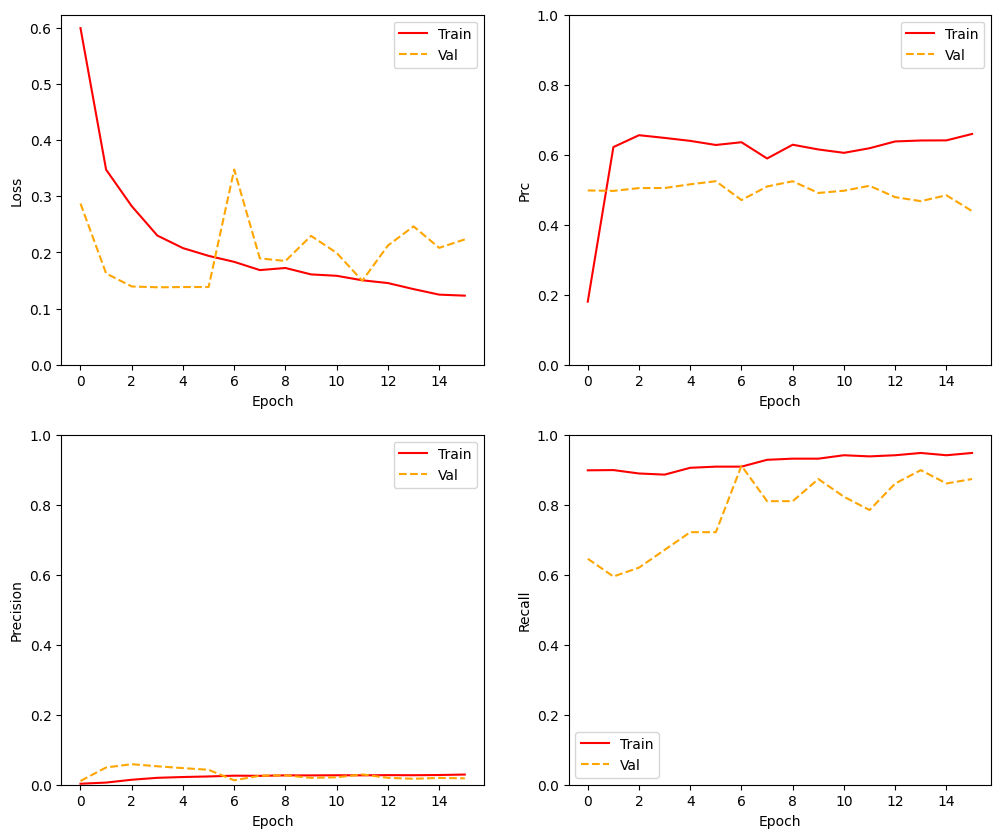

In [ ]:
plot_metrics(weighted_history)

In [ ]:
train_predictions_weighted = weighted_model.predict(x_train, batch_size=2048)
test_predictions_weighted = weighted_model.predict(x_test, batch_size=2048)

28/28 [==============================] - 0s 3ms/step


loss :  0.11560118943452835
cross entropy :  0.11560118943452835
Brier score :  0.021969595924019814
tp :  97.0
fp :  1054.0
tn :  55802.0
fn :  9.0
accuracy :  0.9813384413719177
precision :  0.0842745453119278
recall :  0.9150943160057068
auc :  0.9785656929016113
prc :  0.7351850867271423

Legitimate Transactions Detected (True Negatives):  55802
Legitimate Transactions Incorrectly Detected (False Positives):  1054
Fraudulent Transactions Missed (False Negatives):  9
Fraudulent Transactions Detected (True Positives):  97
Total Fraudulent Transactions:  106


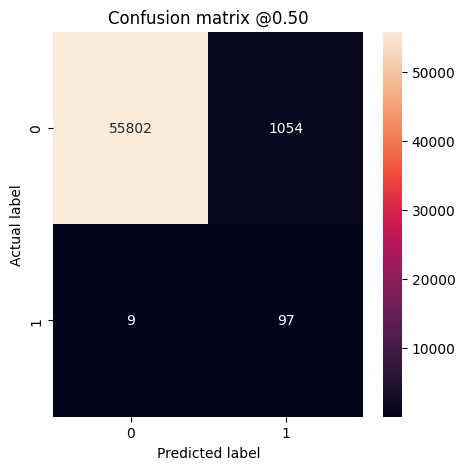

In [ ]:
weighted_results = weighted_model.evaluate(x_test, y_test,
                                           batch_size=2048, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

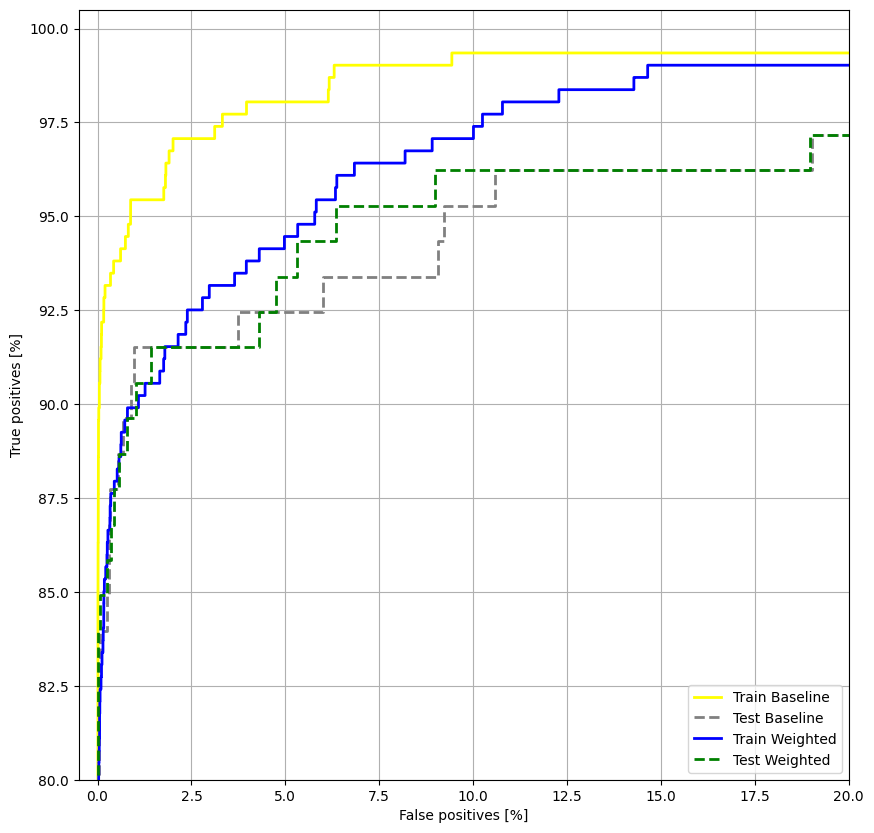

In [ ]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color='yellow',  linestyle='solid')
plot_roc("Test Baseline", y_test, test_predictions_baseline, color='grey', linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color='blue',  linestyle='solid')
plot_roc("Test Weighted", y_test, test_predictions_weighted, color='green', linestyle='--')


plt.legend(loc='lower right');

In [ ]:
pos_features = x_train[bool_train_labels]
neg_features = x_train[~bool_train_labels]
pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181947, 30)

In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363894, 30)

In [ ]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 1.23423505e+00  3.01974042e+00 -4.30459688e+00  4.73279513e+00
  3.62420083e+00 -1.35774566e+00  1.71344499e+00 -4.96358487e-01
 -1.28285782e+00 -2.44746926e+00  2.10134387e+00 -4.60962839e+00
  1.46437762e+00 -6.07933719e+00 -3.39237373e-01  2.58185095e+00
  6.73938438e+00  3.04249318e+00 -2.72185312e+00  9.06083640e-03
 -3.79068307e-01 -7.04181032e-01 -6.56804756e-01 -1.63265296e+00
  1.48890145e+00  5.66797273e-01 -1.00162235e-02  1.46792735e-01
  1.00000000e+00  9.99500333e-04]

Label:  1


In [ ]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(2048).prefetch(2)

In [ ]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.50537109375


In [ ]:
resampled_steps_per_epoch = np.ceil(2.0*neg/2048)
resampled_steps_per_epoch

278.0

In [ ]:
resampled_model = make_model()

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).cache()
val_ds = val_ds.batch(2048).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=100,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 30s 90ms/step - loss: 1.3593 - cross entropy: 1.2462 - Brier score: 0.1156 - tp: 234314.0000 - fp: 45303.0000 - tn: 296289.0000 - fn: 50400.0000 - accuracy: 0.8472 - precision: 0.8380 - recall: 0.8230 - auc: 0.9005 - prc: 0.9029 - val_loss: 0.1025 - val_cross entropy: 0.1025 - val_Brier score: 0.0212 - val_tp: 60.0000 - val_fp: 828.0000 - val_tn: 44670.0000 - val_fn: 11.0000 - val_accuracy: 0.9816 - val_precision: 0.0676 - val_recall: 0.8451 - val_auc: 0.9581 - val_prc: 0.5977
Epoch 2/100
278/278 [==============================] - 25s 89ms/step - loss: 0.1348 - cross entropy: 0.1348 - Brier score: 0.0387 - tp: 260156.0000 - fp: 6832.0000 - tn: 278106.0000 - fn: 24250.0000 - accuracy: 0.9454 - precision: 0.9744 - recall: 0.9147 - auc: 0.9889 - prc: 0.9904 - val_loss: 0.0618 - val_cross entropy: 0.0618 - val_Brier score: 0.0139 - val_tp: 60.0000 - val_fp: 666.0000 - val_tn: 44832.0000 - val_fn: 11.0000 - val_accuracy: 0.9851 - val_pr

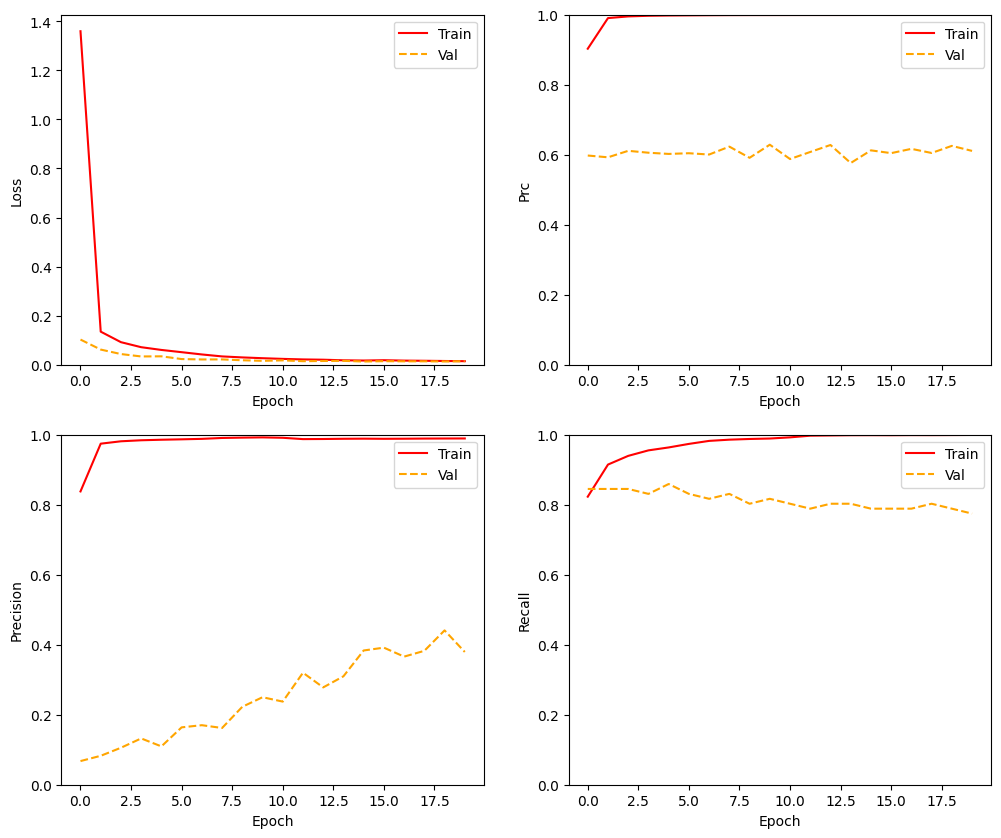

In [ ]:
plot_metrics(resampled_history)

In [ ]:
resampled_model = make_model()
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch=20,
    epochs=10*100,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 5s 141ms/step - loss: 4.0399 - cross entropy: 1.9198 - Brier score: 0.1601 - tp: 12447.0000 - fp: 10233.0000 - tn: 55899.0000 - fn: 7950.0000 - accuracy: 0.7899 - precision: 0.5488 - recall: 0.6102 - auc: 0.8262 - prc: 0.5671 - val_loss: 0.5978 - val_cross entropy: 0.5978 - val_Brier score: 0.2046 - val_tp: 51.0000 - val_fp: 13538.0000 - val_tn: 31960.0000 - val_fn: 20.0000 - val_accuracy: 0.7025 - val_precision: 0.0038 - val_recall: 0.7183 - val_auc: 0.7639 - val_prc: 0.1586
Epoch 2/1000
20/20 [==============================] - 2s 101ms/step - loss: 1.8986 - cross entropy: 1.8986 - Brier score: 0.2354 - tp: 15317.0000 - fp: 8247.0000 - tn: 12187.0000 - fn: 5209.0000 - accuracy: 0.6715 - precision: 0.6500 - recall: 0.7462 - auc: 0.7367 - prc: 0.7373 - val_loss: 0.4600 - val_cross entropy: 0.4600 - val_Brier score: 0.1438 - val_tp: 52.0000 - val_fp: 6857.0000 - val_tn: 38641.0000 - val_fn: 19.0000 - val_accuracy: 0.8491 - val_precisi

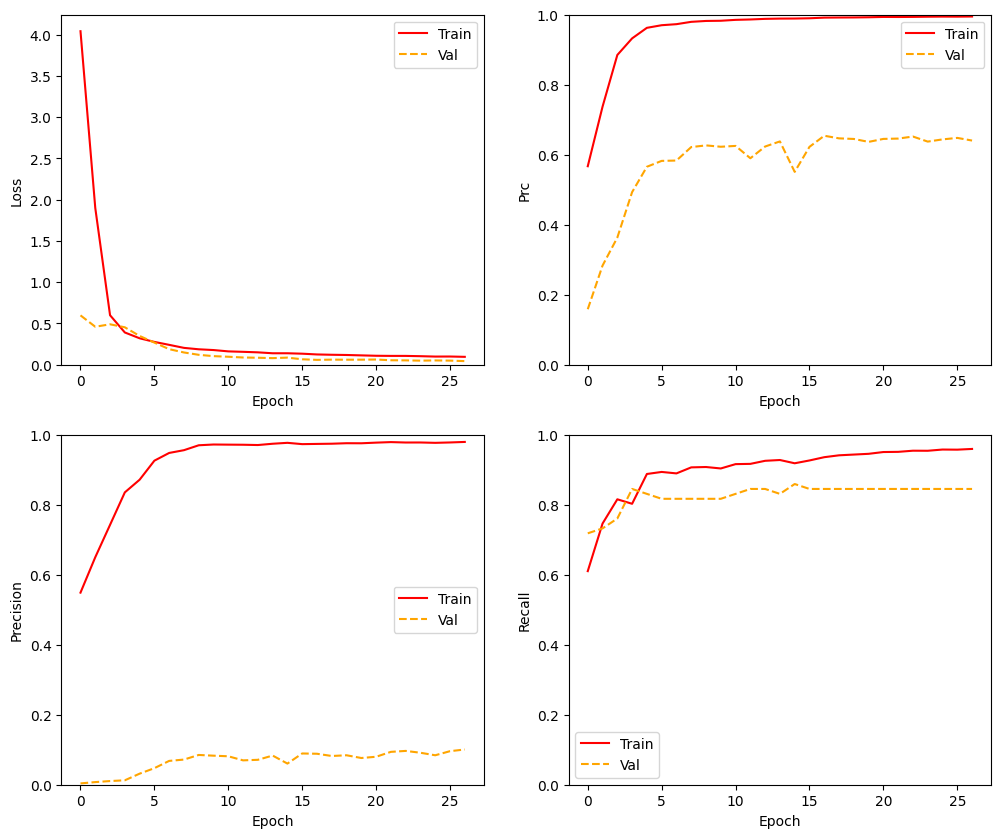

In [ ]:
plot_metrics(resampled_history)

In [ ]:
train_predictions_resampled = resampled_model.predict(x_train, batch_size=2048)
test_predictions_resampled = resampled_model.predict(x_test, batch_size=2048)

28/28 [==============================] - 0s 4ms/step


loss :  0.05972360819578171
cross entropy :  0.05972360819578171
Brier score :  0.012493732385337353
tp :  75.0
fp :  764.0
tn :  56106.0
fn :  17.0
accuracy :  0.9862890839576721
precision :  0.08939213305711746
recall :  0.8152173757553101
auc :  0.9666959643363953
prc :  0.6223450899124146

Legitimate Transactions Detected (True Negatives):  56106
Legitimate Transactions Incorrectly Detected (False Positives):  764
Fraudulent Transactions Missed (False Negatives):  17
Fraudulent Transactions Detected (True Positives):  75
Total Fraudulent Transactions:  92


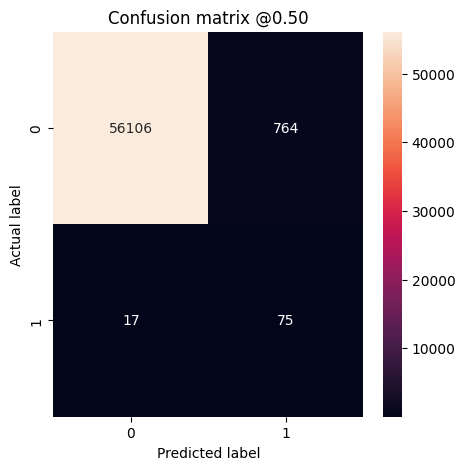

In [ ]:
resampled_results = resampled_model.evaluate(x_test, y_test,
                                             batch_size=2048, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()
plot_cm(y_test, test_predictions_resampled)